मी असे म्हणेन की वृत्तपत्र आले नाही
या वर्षी निवडणूक होईल काय?
प्रत्येक वेळी आपण प्रयत्न केला पाहिजे
इतकी वर्षे जे झाले ते पुन्हा होऊ नये म्हणून प्रयत्न केला पाहिजे असे मला वाटते
काही सुधारणा करता येईल का असा आपण विचार केला पाहिजे
मला सरकारला अशी विनंती करावयाची आहे की इतकी वर्षे जे झाले ते पुन्हा होऊ नये म्हणून प्रयत्न केला पाहिजे
हल्लीची परिस्तिथी लक्षात घेऊन हल्ली काटकसर करता येईल की नाही


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!sudo apt-get install -y tesseract-ocr
!pip install pytesseract
!pip install pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,831 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [3]:
pip install --upgrade pillow


Enter text (single word, phrase, or sentence): मी असे म्हणेन की वृत्तपत्र आले नाही


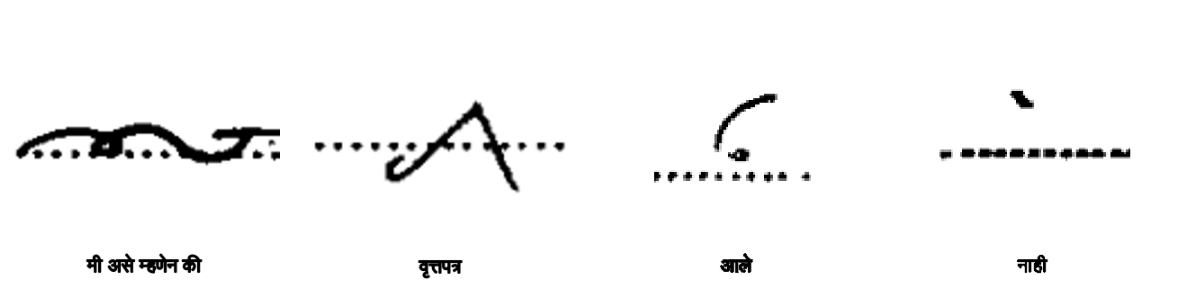

In [5]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os
import re

# Ensure pytesseract knows where Tesseract is installed (if OCR is used)
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Function to validate the image directory
def validate_images_path(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"The directory '{path}' does not exist.")
    if not any(os.scandir(path)):
        raise FileNotFoundError(f"The directory '{path}' is empty.")
    return path

# Function to display images with Marathi titles
def display_images_horizontal_with_marathi(images, titles, font_path):
    num_images = len(images)

    # Load the Marathi-compatible font
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"Font file not found at {font_path}. Please upload a valid .ttf font.")
    try:
        font = ImageFont.truetype(font_path, size=20)
    except Exception as e:
        raise Exception(f"Failed to load font: {e}")

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    if num_images == 1:  # Ensure axes is iterable for a single image
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        if img:
            # Draw title directly on the image
            try:
                draw = ImageDraw.Draw(img)
                text_bbox = draw.textbbox((0, 0), title, font=font)  # Get text bounding box
                text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
                text_position = ((img.width - text_width) // 2, img.height - text_height - 10)  # Bottom-center
                draw.text(text_position, title, fill="black", font=font, stroke_width=1, stroke_fill="black")
                ax.imshow(img)
            except Exception as e:
                print(f"Error drawing title '{title}' on image: {e}")
        else:
            ax.text(0.5, 0.5, "Not Found", ha='center', va='center', fontsize=10, color='red')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Function to find and process word chains
def find_word_chains(input_text, images_path):
    matched_results = []
    processed_indices = set()  # Tracks indices of words already processed as part of a chain

    words = re.split(r'\s+', input_text.strip())
    total_words = len(words)

    # Process chains starting from the longest possible sequence
    for start in range(total_words):
        for end in range(total_words, start, -1):  # Go from longest to shortest
            phrase = ' '.join(words[start:end]).strip()

            # Skip if any part of the chain is already processed
            if any(i in processed_indices for i in range(start, end)):
                continue

            # Search for matching images
            matched = False
            for root, dirs, files in os.walk(images_path):
                for file in files:
                    if phrase == os.path.splitext(file)[0]:  # Exact match with filename (ignores extension)
                        img_path = os.path.join(root, file)
                        matched_results.append((Image.open(img_path), phrase))
                        # Mark indices of this chain as processed
                        processed_indices.update(range(start, end))
                        matched = True
                        break
                if matched:
                    break

            if matched:
                break  # Skip shorter chains once the longest match is found

    # Check for words that are not part of any matched chain
    for i, word in enumerate(words):
        if i not in processed_indices:
            matched_results.append((None, word))  # No image found, but show the word

    return matched_results

# Main function to process text input and display images
def process_and_display_images(input_text, images_path, font_path):
    matches = find_word_chains(input_text, images_path)
    if matches:
        images, titles = zip(*matches)
        # Convert images to PIL format
        pil_images = [img.resize((300, 300)) if img else None for img in images]
        display_images_horizontal_with_marathi(pil_images, titles, font_path)
    else:
        print("No matches found for the given input.")

# Input and execution
try:
    images_path = validate_images_path('/content/drive/MyDrive/miniproj/Barphe maam')  # Update with your dataset path
    font_path = '/content/drive/MyDrive/miniproj/lohit-devanagari.ttf'  # Update with your font path
    user_input = input("Enter text (single word, phrase, or sentence): ").strip()
    if user_input:
        process_and_display_images(user_input, images_path, font_path)
    else:
        print("No input provided.")
except Exception as e:
    print(f"Error: {e}")
